In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import datetime

import tensorflow as tf
import tfimm

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy
from PIL import Image
from  tensorflow.keras.callbacks import EarlyStopping
from custom_head import add_layers


In [2]:
# Load your dataframe
data_dir = 'data/ODIR5K/bence/'

df = pd.read_csv(data_dir + 'train_df.csv', index_col=0)
df.set_index(["ID"], inplace=True)
df.drop(["Patient Sex"], axis=1, inplace=True)

img_dir= data_dir + 'train/'
labels = df["Patient Age"].values
image_names = df["Left-Fundus"].values
img_paths = img_dir + image_names

# def crop_to_square(image):
#     shape = tf.shape(image)
#     height, width = shape[0], shape[1]
#     new_side = tf.minimum(height, width)
#     offset_height = (height - new_side) // 2
#     offset_width = (width - new_side) // 2
#     image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, new_side, new_side)
#     return image

# Create dataset
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  
    image = image / 255.0 
    return image, label

def preprocess_dataset(image_names, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_names, labels))
    dataset = dataset.map(lambda x, y: load_image(x, y))
    return dataset

train_dataset = preprocess_dataset(img_paths, labels)
batch_size = 16
train_dataset = train_dataset.batch(batch_size)
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

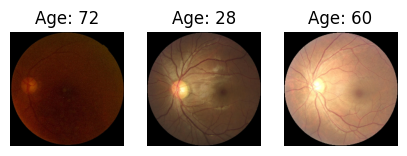

(16, 224, 224, 3)
Max pixel value: 1.0
Min pixel value: 0.0
Mean pixel value: 0.2285321
Pixel value range: 1.0


In [3]:
# visualize some images

def plot_images(images, labels, num_images=3, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(f'Age: {labels[i]}')
        plt.axis('off')
    plt.show()


# Get a batch of images and labels
for images, labels in train_dataset.take(1):  # Take one batch
    plot_images(images.numpy(), labels.numpy())

    # Convert images to numpy array for analysis
    images_np = images.numpy()

    # Print pixel value statistics
    print(images.shape)
    print("Max pixel value:", np.max(images_np))
    print("Min pixel value:", np.min(images_np))
    print("Mean pixel value:", np.mean(images_np))
    print("Pixel value range:", np.max(images_np) - np.min(images_np))
    break

In [4]:
# Create validation dataset
df = pd.read_csv(data_dir + 'val_df.csv', index_col=0)
df.set_index(["ID"], inplace=True)
df.drop(["Patient Sex"], axis=1, inplace=True)

img_dir= data_dir + 'val/'
labels = df["Patient Age"].values
image_names = df["Left-Fundus"].values
img_paths = img_dir + image_names

val_dataset = preprocess_dataset(img_paths, labels)
print("len val_dataset:", len(val_dataset))
val_dataset = val_dataset.batch(batch_size)
val_dataset

len val_dataset: 365


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [5]:
# Create validation dataset
df = pd.read_csv(data_dir + 'test_df.csv', index_col=0)
df.set_index(["ID"], inplace=True)
df.drop(["Patient Sex"], axis=1, inplace=True)

img_dir= data_dir + 'test/'
labels = df["Patient Age"].values
image_names = df["Left-Fundus"].values
img_paths = img_dir + image_names

test_dataset = preprocess_dataset(img_paths, labels)
print("len test ds:", len(test_dataset))
test_dataset = test_dataset.batch(batch_size)
test_dataset


len test ds: 203


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

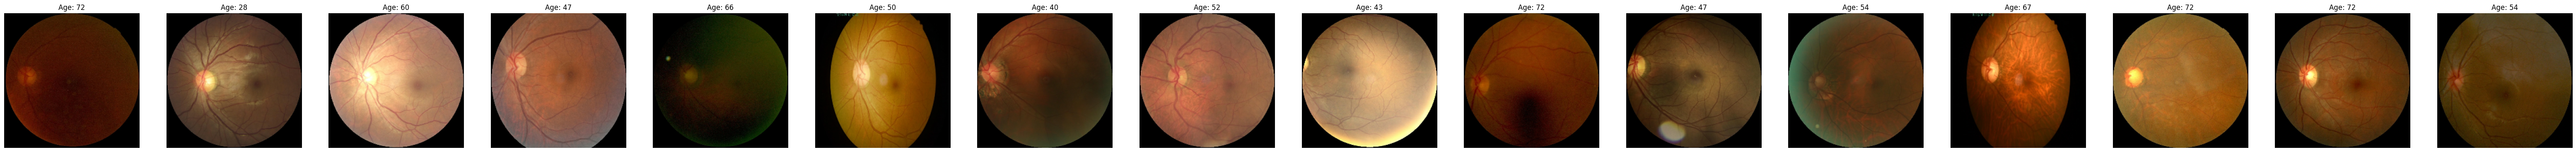

In [46]:
# Optional: Data Augmentation!

random_seed = 42

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.25, seed=random_seed, fill_mode='constant'),
    tf.keras.layers.RandomZoom(height_factor=0.1, seed=random_seed, fill_mode='constant'),
    tf.keras.layers.RandomContrast(factor=0.2, seed=random_seed),
    # tf.keras.layers.RandomBrightness(factor=0.2, seed=random_seed) # not recognized
])
def augment(image, label):
    image = data_augmentation(image)
    return image, label

augmented_train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
for images, labels in augmented_train_dataset.take(1):  # Take one batch
    plot_images(images.numpy(), labels.numpy(), num_images=batch_size, figsize=(80, 80))


In [47]:
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [7]:
# Create the base model
model_name = "vit_large_patch16_224"
base_model = tfimm.create_model(
    model_name,
    nb_classes=0  # this removes the final layer
)

# Load base_model weights (by_name=True because nb_classes=0 removes a layer)
model_path = "RETFound_CFP_weights.h5" # get from RETFound github

base_model.load_weights(model_path, by_name=True, skip_mismatch=False)
base_model.trainable = False
# base_model.summary()

# Input layer
input_shape = (224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)

# ViT layer
x = base_model(inputs)

# Custom head here ---------------------------------------------------------
custom_head = "minigen"

for layer in add_layers(custom_head):
    x = layer(x)

# --------------------------------------------------------------------------


prediction = tf.keras.layers.Dense(1, activation='relu',name='head')(x)

# early stopping, patience 50 kb - ez kevés, mert megáll 7-8 évnél

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=prediction)
model.summary()


Loading:  minigen
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit_large_patch16_224 (ViT)  (None, 1024)             303301632 
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation_25 (Activation)  (None, 1024)              0         
                                                                 
 dropout_97 (Dropout)        (None, 1024)              0         
                                           

In [8]:
epochs = 500
print("epochs: "+str(epochs))

epochs: 500


In [9]:
import tensorflow_addons as tfa
from scheduler import WarmUpCosine



num_batches = tf.data.experimental.cardinality(train_ds)
num_samples = num_batches.numpy() * batch_size
print("num_batches: "+str((tf.data.experimental.cardinality(train_ds).numpy())))
print("num_samples: "+str(num_samples))

### Set optimization parameters
steps = int((num_samples // batch_size) * epochs)
warmup_steps = int(steps * 0.1)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=5e-4,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)
print("warmup_steps: "+str(warmup_steps))
print("steps: "+str(steps))

optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=1e-4)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['mean_absolute_error'])


num_batches: 92
num_samples: 1472
warmup_steps: 4600
steps: 46000


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['mean_absolute_error'])

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

model.load_weights('CFPmodel_20240916-l2048-1024-1024-b8-defadam-e500_pali2_continue.h5')
# model.load_weights('Write the .h5 model name here, but make sure it is the same architecture as the model you are using')

ValueError: Layer count mismatch when loading weights from file. Model expected 4 layers, found 8 saved layers.

In [11]:
custommodelname ="-minigen-b16-defadam-e500"
print("CUSTOM NAME OF THE MODEL IS:")
print(custommodelname)

CUSTOM NAME OF THE MODEL IS:
-minigen-b16-defadam-e500


In [12]:
 #callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, min_delta=0.1)
save_best_model = ModelCheckpoint( ('CFPmodel_'+ datetime.datetime.now().strftime("%Y%m%d")+custommodelname  + 'best_val_loss_weights.h5') , monitor='val_loss', mode='min',save_best_only=True,verbose=1)


In [13]:
%load_ext tensorboard
# launch from console with command: tensorboard --logdir=./

In [14]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + custommodelname
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=[tensorboard_callback] #, es, save_best_model]
)

Epoch 1/500
92/92 [==============================] - 79s 735ms/step - loss: 40.2756 - mean_absolute_error: 40.2756 - val_loss: 49.3481 - val_mean_absolute_error: 49.3481
Epoch 2/500
92/92 [==============================] - 64s 696ms/step - loss: 14.5284 - mean_absolute_error: 14.5284 - val_loss: 74.8539 - val_mean_absolute_error: 74.8539
Epoch 3/500
92/92 [==============================] - 65s 703ms/step - loss: 10.8093 - mean_absolute_error: 10.8093 - val_loss: 43.8072 - val_mean_absolute_error: 43.8072
Epoch 4/500
92/92 [==============================] - 65s 704ms/step - loss: 10.1019 - mean_absolute_error: 10.1019 - val_loss: 21.4590 - val_mean_absolute_error: 21.4590
Epoch 5/500
92/92 [==============================] - 65s 710ms/step - loss: 9.8170 - mean_absolute_error: 9.8170 - val_loss: 15.4100 - val_mean_absolute_error: 15.4100
Epoch 6/500
92/92 [==============================] - 65s 712ms/step - loss: 9.4325 - mean_absolute_error: 9.4325 - val_loss: 9.1532 - val_mean_absolute_

In [15]:
model.save_weights('CFPmodel_'+ datetime.datetime.now().strftime("%Y%m%d")+custommodelname+'.h5')

In [ ]:
# tf record-al érdemes menteni a train részleteit. Tanításhoz gyorsítani, data API.

In [16]:
# Inference
ylabels = []
for _, labels in val_dataset:
    ylabels.extend(labels.numpy())
ylabels

ypred = model.predict(val_dataset)


In [17]:
mae = np.mean(np.abs(np.array(ylabels) - ypred.flatten()))
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 7.787245669430249


CFPmodel_20241002-minigen-b4-defadam-e100: 7.6682136326620025
CFPmodel_20241002-minigen-b16-defadam-e100: 6.14649889175206
CFPmodel_20241003-minigen-b32-defadam-e100: 6.5834922738271215, b32 was very similar to b16 but took longer.
CFPmodel_20241002-minigen-b16-defadam-e100-augment: 6.67318643021257, augmentation showed no major difference but took longer.
CFPmodel_20241007-minigen-b16-defadam-e500: 7.787245669430249 overfit

Pearson correlation coefficient: 0.6409920482284746


Text(0.5, 1.0, 'Predicted vs True Age - Validation Set')

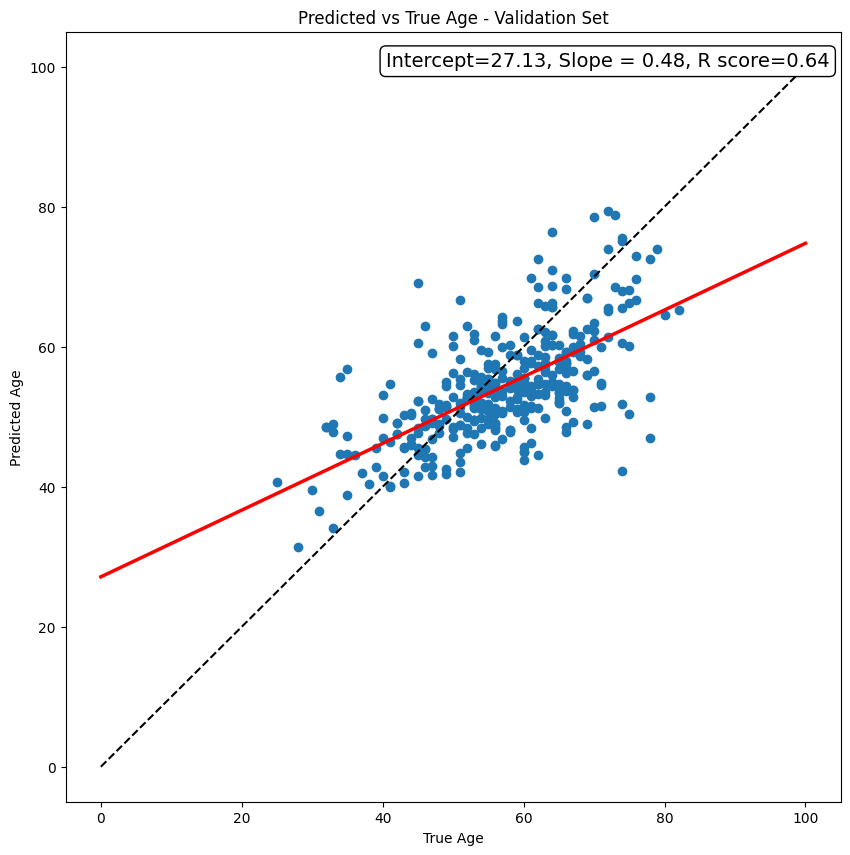

In [19]:
# Plot the results
plt.figure(figsize=(10, 10))
plt.scatter(ylabels, ypred)
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')

# Calculate linear regression parameters
slope, intercept = np.polyfit(ylabels, ypred, 1)
# print(f"Slope: {slope}, Intercept: {intercept}")
b=slope
a=intercept


# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 100, num=1000)
# print(xseq)

# Plot regression line
plt.plot(xseq, a + b * xseq, color="r", lw=2.5)


# Calculate Pearson correlation coefficient
correlation = np.corrcoef(ylabels, ypred.flatten())[0, 1]
print(f"Pearson correlation coefficient: {correlation}")

plt.annotate((f"Intercept={np.round(a,2)[0]}"+f", Slope = {np.round(b,2)[0]}"+f", R score={np.round(correlation,2)}"),xy=(550, 540), xycoords='axes points',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))

plt.title('Predicted vs True Age - Validation Set')

In [20]:
# Inference test dataset
ylabels = []
for _, labels in test_dataset:
    ylabels.extend(labels.numpy())
ylabels

ypred = model.predict(test_dataset)


Pearson correlation coefficient: 0.5979816675330374


Text(0.5, 1.0, 'Predicted vs True Age - Test Set')

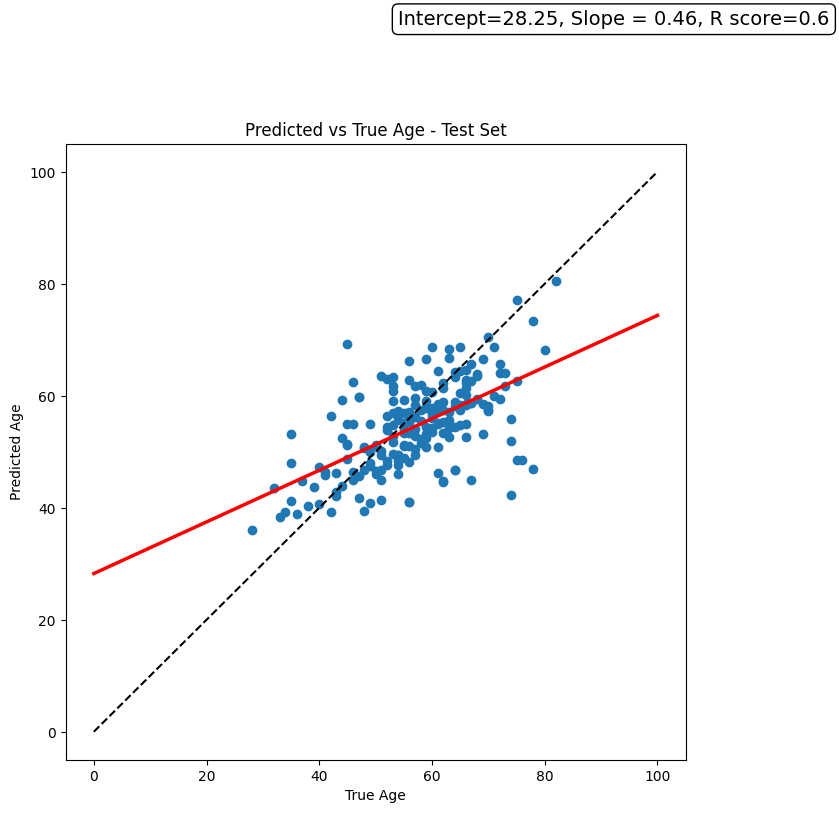

In [21]:
# Plot the results
plt.figure(figsize=(8, 8))
plt.scatter(ylabels, ypred)
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')

# Calculate linear regression parameters
slope, intercept = np.polyfit(ylabels, ypred, 1)
# print(f"Slope: {slope}, Intercept: {intercept}")
b=slope
a=intercept


# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 100, num=1000)
# print(xseq)

# Plot regression line
plt.plot(xseq, a + b * xseq, color="r", lw=2.5)


# Calculate Pearson correlation coefficient
correlation = np.corrcoef(ylabels, ypred.flatten())[0, 1]
print(f"Pearson correlation coefficient: {correlation}")

plt.annotate((f"Intercept={np.round(a,2)[0]}"+f", Slope = {np.round(b,2)[0]}"+f", R score={np.round(correlation,2)}"),xy=(550, 540), xycoords='axes points',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))

plt.title('Predicted vs True Age - Test Set')

In [67]:
from scipy.stats import norm

In [119]:
# Create PAPILA test dataset

data_dir = 'data/PAPILA/SelectedHealthyImages/'

df = pd.read_csv(data_dir + 'df_healthy.csv', index_col=0)
df.set_index(["index"], inplace=True)
df.index = df.index.map(lambda x: f"{x:03}")
df["filename"] = "RET" + df.index.astype(str) + "OS.jpg"

img_dir= data_dir
labels = df["Age"].values
image_names = df["filename"].values
img_paths = img_dir + image_names



PAPILA_dataset = preprocess_dataset(img_paths, labels)
print("len val_dataset:", len(PAPILA_dataset))
PAPILA_dataset = PAPILA_dataset.batch(batch_size)
PAPILA_dataset

len val_dataset: 163


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Pearson correlation coefficient: -0.04803243324611271


Text(0.5, 1.0, 'Predicted vs True Age - PAPILA test set')

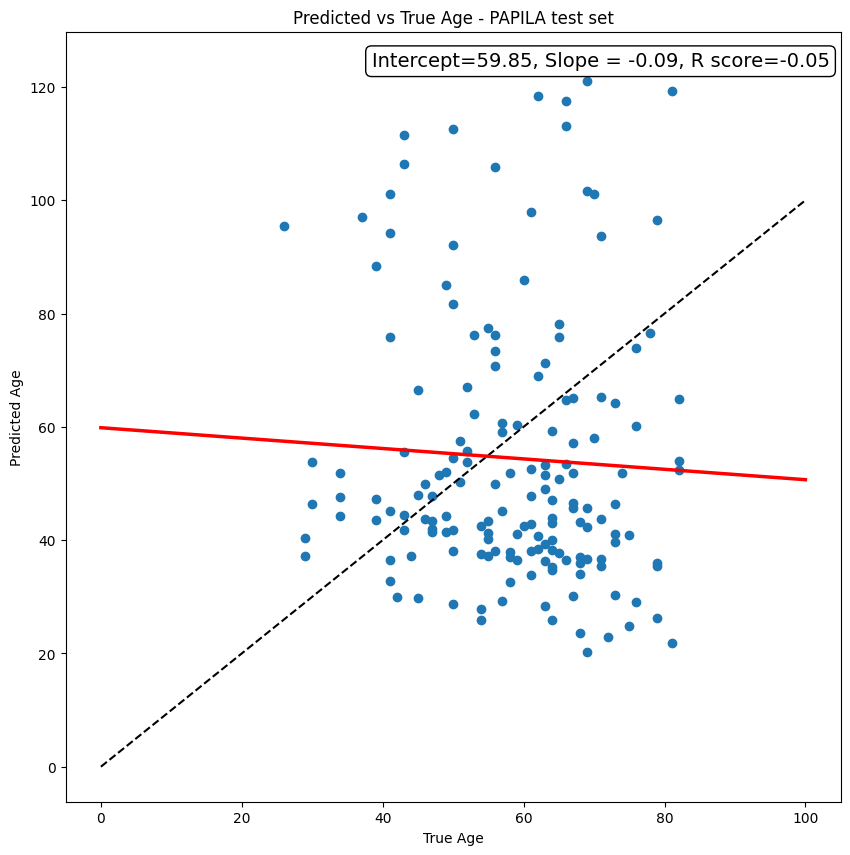

In [120]:
# Inference PAPILA_dataset
ylabels = []
for _, labels in PAPILA_dataset:
    ylabels.extend(labels.numpy())
ylabels

ypred = model.predict(PAPILA_dataset)

# Plot the results
plt.figure(figsize=(8, 8))
plt.scatter(ylabels, ypred)
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')

# Calculate linear regression parameters
slope, intercept = np.polyfit(ylabels, ypred, 1)
# print(f"Slope: {slope}, Intercept: {intercept}")
b=slope
a=intercept


# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 100, num=1000)
# print(xseq)

# Plot regression line
plt.plot(xseq, a + b * xseq, color="r", lw=2.5)


# Calculate Pearson correlation coefficient
correlation = np.corrcoef(ylabels, ypred.flatten())[0, 1]
print(f"Pearson correlation coefficient: {correlation}")

plt.annotate((f"Intercept={np.round(a,2)[0]}"+f", Slope = {np.round(b,2)[0]}"+f", R score={np.round(correlation,2)}"),xy=(550, 540), xycoords='axes points',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))

plt.title('Predicted vs True Age - PAPILA test set')